In [11]:
import pandas as pd

# Load datasets
df_patient = pd.read_csv('patientMonitoring.csv')
df_environment = pd.read_csv('environmentMonitoring.csv')
df_attack = pd.read_csv('Attack.csv')

# Filter only normal samples (label == 0) for training
df_normal = pd.concat([
    df_patient[df_patient['label'] == 0],
    df_environment[df_environment['label'] == 0]
], ignore_index=True)

# Attack data as test (label == 1)
df_attack = df_attack[df_attack['label'] == 1]

print(f"Normal data shape: {df_normal.shape}")
print(f"Attack data shape: {df_attack.shape}")


C:\Users\fawad\AppData\Local\Temp\ipykernel_4020\809023645.py:4: DtypeWarning: Columns (26,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_patient = pd.read_csv('patientMonitoring.csv')


Normal data shape: (108568, 52)
Attack data shape: (80126, 52)


C:\Users\fawad\AppData\Local\Temp\ipykernel_4020\809023645.py:6: DtypeWarning: Columns (26,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_attack = pd.read_csv('Attack.csv')


In [12]:

for col in features:
    non_numeric = df_attack[~df_attack[col].apply(lambda x: isinstance(x, (int, float, complex)))][col]
    if not non_numeric.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric)# Convert mqtt.msg to numeric, coercing errors to NaN
df_attack['mqtt.msg'] = pd.to_numeric(df_attack['mqtt.msg'], errors='coerce')
df_normal['mqtt.msg'] = pd.to_numeric(df_normal['mqtt.msg'], errors='coerce')

# Fill any NaNs generated by coercion with 0 or appropriate value
df_attack['mqtt.msg'] = df_attack['mqtt.msg'].fillna(0)
df_normal['mqtt.msg'] = df_normal['mqtt.msg'].fillna(0)
for col in features:
    if df_attack[col].dtype == 'object':
        df_attack[col] = pd.to_numeric(df_attack[col], errors='coerce').fillna(0)
    if df_normal[col].dtype == 'object':
        df_normal[col] = pd.to_numeric(df_normal[col], errors='coerce').fillna(0)

Non-numeric values in column 'mqtt.msg':
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
80121      0
80122      0
80123      0
80124      0
80125      0
Name: mqtt.msg, Length: 80126, dtype: object


In [13]:
from sklearn.preprocessing import StandardScaler

# Columns to drop (non-numeric or identifiers)
drop_cols = ['ip.src', 'ip.dst', 'mqtt.clientid', 'class', 'label', 'source']  # add more if needed

# Keep only features (numeric columns)
# Select numeric columns only
features = df_normal.select_dtypes(include=['number']).columns.tolist()

# Now scale
scaler = StandardScaler()
normal_scaled = scaler.fit_transform(df_normal[features])
attack_scaled = scaler.transform(df_attack[features])


In [14]:
import numpy as np

def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10

X_train = create_sequences(normal_scaled, seq_length)
X_test = create_sequences(attack_scaled, seq_length)

print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")


Training sequences shape: (108559, 10, 41)
Test sequences shape: (80117, 10, 41)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def build_lstm_autoencoder(seq_len, num_features):
    inputs = Input(shape=(seq_len, num_features))
    encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(num_features))(decoded)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_autoencoder(seq_length, X_train.shape[2])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 41)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 41)         │         2,665 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,825 (245.41 KB)

 Trainable params: 62,825 (245.41 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # What to monitor
    patience=5,               # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore weights from best epoch
)
history = model.fit(
    X_train, X_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.4401 - val_loss: 0.2868
Epoch 2/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.1836 - val_loss: 0.2450
Epoch 3/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1173 - val_loss: 0.2240
Epoch 4/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0737 - val_loss: 0.2059
Epoch 5/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 0.0632 - val_loss: 0.1755
Epoch 6/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0466 - val_loss: 0.1617
Epoch 7/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.0479 - val_loss: 0.1488
Epoch 8/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 779s 575ms/step - loss: 0.0395 - val_loss: 0.1405
Epoch 9/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0427 - val_loss: 0.1447
Epoch 10/10
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0416 - val_loss: 0.1414


2504/2504 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


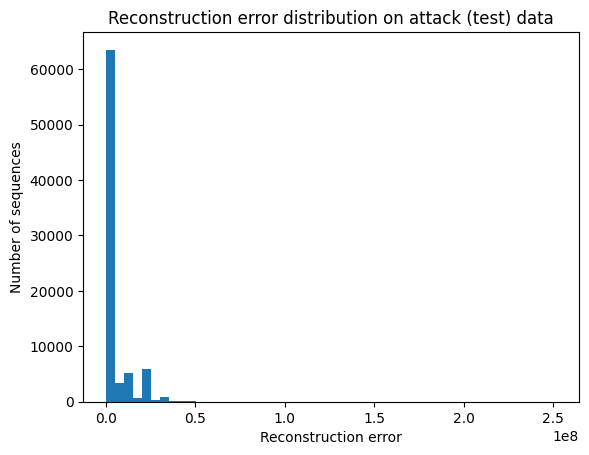

In [17]:
# Predict reconstruction on test set
X_test_pred = model.predict(X_test)

# Compute mean squared error for each sequence
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=(1,2))

import matplotlib.pyplot as plt
plt.hist(mse, bins=50)
plt.xlabel('Reconstruction error')
plt.ylabel('Number of sequences')
plt.title('Reconstruction error distribution on attack (test) data')
plt.show()


In [18]:
# Reconstruction error on training data
X_train_pred = model.predict(X_train)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=(1,2))

threshold = np.percentile(mse_train, 95)
print(f"Anomaly detection threshold (95 percentile): {threshold}")

# Detect anomalies in test data
anomalies = mse > threshold
print(f"Detected {np.sum(anomalies)} anomalies out of {len(anomalies)} test sequences")


3393/3393 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
Anomaly detection threshold (95 percentile): 0.23522475599449064
Detected 80117 anomalies out of 80117 test sequences


In [19]:
model.input_shape
# Make random input of same shape as expected by model (1, 10, 41)
random_input = np.random.rand(1, 10, 41)
prediction = model.predict(random_input)

error = np.mean(np.square(random_input - prediction))
print("Reconstruction Error:", error)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Reconstruction Error: 0.3219815341600075


In [20]:
error = np.mean(np.square(random_input - prediction))
print("Reconstruction Error:", error)

threshold = 0.01  # Example threshold based on validation error
if error > threshold:
    print("⚠️ Anomaly detected")
else:
    print("✅ Normal input")


Reconstruction Error: 0.3219815341600075
⚠️ Anomaly detected
